In [ ]:
# Step 1: Install & Import Necessary Libraries
!pip install kagglehub pandas numpy seaborn matplotlib scikit-learn

import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Step 2: Download Dataset
def download_dataset():
    path = kagglehub.dataset_download("shashanks1202/apartment-rent-data")
    print("Path to dataset files:", path)

download_dataset()

Path to dataset files: /root/.cache/kagglehub/datasets/shashanks1202/apartment-rent-data/versions/1


In [ ]:
# Step 3: Upload & Load Dataset
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name, encoding="ISO-8859-1", sep=";")
print(df.info())

Saving apartments_for_rent_classified_10K.csv to apartments_for_rent_classified_10K (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      6451 non-null   object 
 5   bathrooms      9966 non-null   float64
 6   bedrooms       9993 non-null   float64
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   5837 non-null   object 
 11  price          10000 non-null  int64  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        6673 non-null   object 
 16  cit

In [ ]:
# Step 4: Handle Missing Values
def handle_missing_values(df):
    df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
    df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
    df['latitude'].fillna(df['latitude'].median(), inplace=True)
    df['longitude'].fillna(df['longitude'].median(), inplace=True)
    df['amenities'].fillna("Unknown", inplace=True)
    df['pets_allowed'].fillna("Unknown", inplace=True)
    df['address'].fillna("Unknown", inplace=True)
    df['cityname'].fillna(df['cityname'].mode()[0], inplace=True)
    df['state'].fillna(df['state'].mode()[0], inplace=True)
    return df

df = handle_missing_values(df)

<ipython-input-10-50b753d350fd>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
<ipython-input-10-50b753d350fd>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [ ]:
# Step 5: Standardize Categorical Values
def standardize_categorical_values(df):
    df['fee'] = df['fee'].map({'Yes': 1, 'No': 0})
    df['has_photo'] = df['has_photo'].map({'Thumbnail': 1, 'None': 0})
    df['pets_allowed'] = df['pets_allowed'].map({'Yes': 1, 'No': 0, 'Unknown': -1})
    return df

df = standardize_categorical_values(df)

In [ ]:
# Step 6: Extract Numerical Price
def extract_price(df):
    df['price_display'] = df['price_display'].str.extract(r'([\d,]+)')[0]
    df['price_display'] = df['price_display'].str.replace(',', '').astype(float)
    return df

df = extract_price(df)

In [ ]:
# Step 7: Remove Duplicates & Standardize Column Names
df.drop_duplicates(inplace=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [ ]:
# Step 8: Convert UNIX Timestamp to Date
def convert_timestamp(df):
    df['date_listed'] = df['time'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
    df.drop(columns=['time'], inplace=True)
    return df

df = convert_timestamp(df)

In [ ]:
# Step 9: Save Cleaned Dataset
df.to_csv("apartment_rent_cleaned.csv", index=False)
print("Cleaned dataset saved as 'apartment_rent_cleaned.csv'")

Cleaned dataset saved as 'apartment_rent_cleaned.csv'


In [ ]:
# Step 10: Outlier Detection & Removal
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numerical_cols = ['price', 'price_display', 'bathrooms', 'bedrooms', 'square_feet']
for col in numerical_cols:
    df = remove_outliers_iqr(df, col)

print("Dataset shape after outlier removal:", df.shape)

Dataset shape after outlier removal: (8509, 22)


In [ ]:
# Step 11: Drop Irrelevant Columns
columns_to_drop = ['id', 'category', 'source', 'title', 'body']
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Step 12: One-Hot Encoding
df = pd.get_dummies(df, columns=['currency', 'price_type', 'cityname', 'state'], drop_first=True)

In [ ]:
# Step 13: Normalize Numerical Columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Dataset after reshaping:", df.shape)
df.head()

Dataset after reshaping: (8509, 1460)


,amenities,bathrooms,bedrooms,fee,has_photo,pets_allowed,price,price_display,square_feet,address,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,Unknown,0.0,0.000000,0,1.0,-1.0,0.245118,0.245118,0.000000,Unknown,...,False,False,False,False,False,False,False,False,False,False
1,Unknown,0.0,0.333333,0,1.0,-1.0,0.093477,0.093477,0.003418,814 Schutte Rd,...,False,False,False,False,False,False,False,False,False,False
2,Unknown,0.0,0.000000,0,1.0,-1.0,0.494391,0.494391,0.004101,Unknown,...,False,False,False,False,True,False,False,False,False,False
3,Unknown,0.0,0.000000,0,1.0,-1.0,0.301205,0.301205,0.010253,1717 12th Avenue,...,False,False,False,False,False,False,True,False,False,False
4,Unknown,0.0,0.000000,0,1.0,-1.0,0.282509,0.282509,0.016405,Unknown,...,False,False,False,False,True,False,False,False,False,False


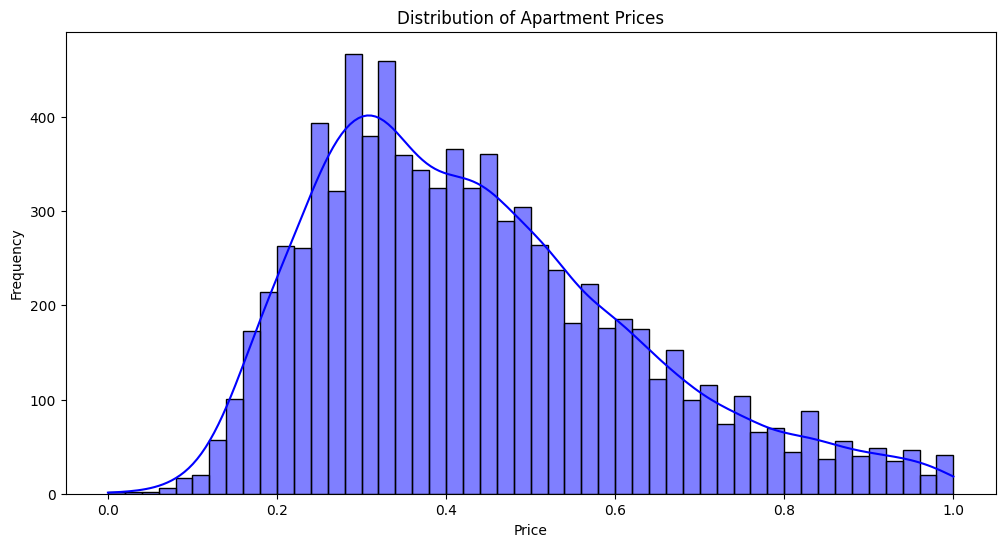

<ipython-input-20-372dda3e72e3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['bathrooms'], y=df['price_display'], palette='coolwarm')


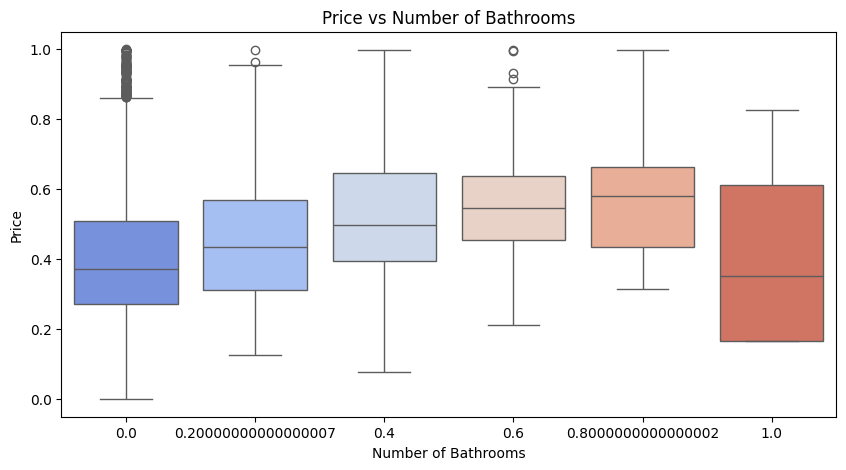

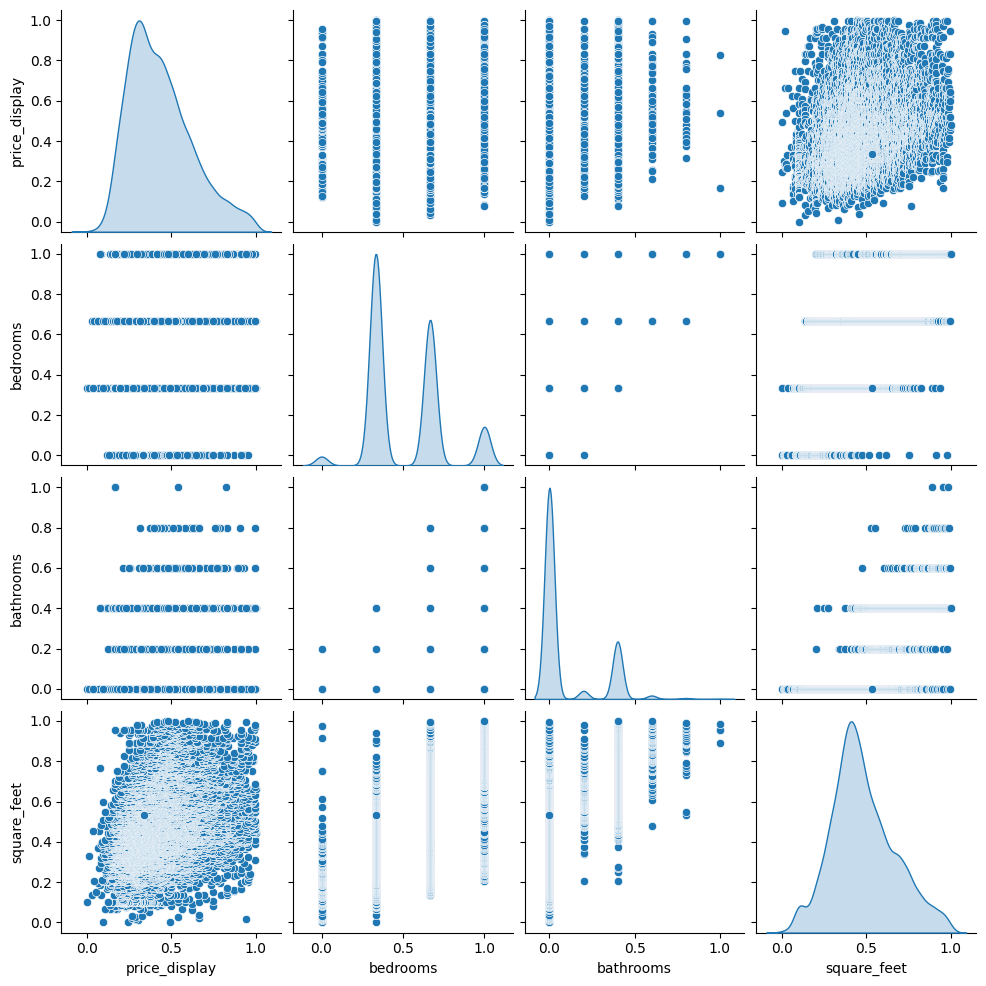

In [ ]:
# Step 14: Data Visualization
plt.figure(figsize=(12, 6))
sns.histplot(df['price_display'], bins=50, kde=True, color='blue')
plt.title("Distribution of Apartment Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['bathrooms'], y=df['price_display'], palette='coolwarm')
plt.title("Price vs Number of Bathrooms")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Price")
plt.show()

sns.pairplot(df[['price_display', 'bedrooms', 'bathrooms', 'square_feet']], diag_kind='kde')
plt.show()